## Pset 5
### Yining Hua

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy.random as rand
import scipy
from matplotlib import pyplot as plt
import seaborn as sns

## 1. reproduce Wiggins' K-means result
Write a standard K-means clustering procedure. Use it to cluster Wiggins' data into K=5 clusters. Plot the results, similar to his figure. You should be able to reproduce a similarly bad result.

You'll want to run the K-means algorithm multiple times and choose the best. What is a good statistic for choosing the "best" solution for K-means? You should be able to reproduce Wiggins' "tot_sqdist" measure.

Why is K-means clustering producing this result, when there are clearly five distinct clusters in the data?

## 3. find a simple fix for K-means
Suggest a simple fix for the problem in applying a standard K-means clustering algorithm to Wiggins' single cell RNA-seq data. Implement the fix, re-run the K-means clustering, pick a "best" solution; report and visualize it.


In [127]:
!head -10 w05-data.tbl

#cell        type      caraway         kiwi
0               2          362          407
1               3           42           61
2               1         3297          787
3               2          359          178
4               4         2552           16
5               1         1555         1165
6               1         2517         1538
7               3           26           23
8               2          371          129


So, type's gonna be our labels.

In [128]:
df = pd.read_table("w05-data.tbl",delim_whitespace=True).rename(columns={"type": "label"})
df[:5]

,#cell,label,caraway,kiwi
0,0,2,362,407
1,1,3,42,61
2,2,1,3297,787
3,3,2,359,178
4,4,4,2552,16


In [129]:
X = np.array(df[["caraway","kiwi"]].astype(int))
y = np.array(df["label"].astype(int))

In [130]:
X.shape

(1000, 2)

In [131]:
y.shape

(1000,)

In [132]:
np.asarray_chkfinite(X).all()

True

Let's take a look at the data distribution before k-clustering them

In [133]:
import math
def visualize(df, marker="o", alpha="0.8"):
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16,6))
    sns.set_style("white")

    for name, group in df.groupby("label"):
        ax1.plot(group.caraway, group.kiwi, marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
        ax2.plot(list(map(math.log,group.caraway)), list(map(math.log,group.kiwi)), marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)

    ax1.set_title("Actual clustering")
    ax1.set_xlabel("caraway(count)")
    ax1.set_ylabel("kiwi(count)")
    ax1.legend()

    ax2.set_title("Actual clustering (log)")
    ax2.set_xlabel("caraway(count)")
    ax2.set_ylabel("kiwi(count)")
    ax2.legend()

    plt.show()

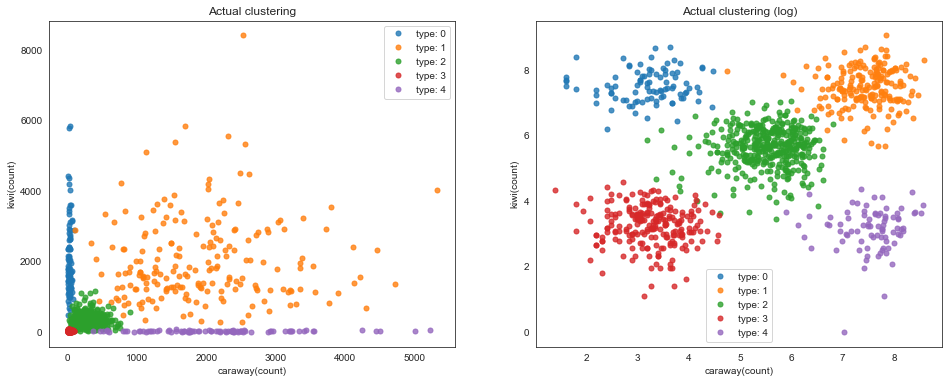

In [134]:
visualize(df)

### Ok, kmeans clustering now

In [135]:
from scipy.spatial import distance
from numpy.linalg import norm

class KMeans:
    def __init__(self, init_method=1, k=5, max_iter=100):
        self.init_method = init_method
        self.k = k
        self.max_iter = max_iter
        self.centers = None
    
    def initialize_cents(self, X):
        """
        initializes the centers in 3 ways
        """    
        if self.init_method == 1:  ## assign random points in the space as the centers 
            min_x, min_y = np.min(X, axis= 0)
            max_x, max_y = np.max(X, axis= 0)
            return np.array(list(zip(rand.choice(np.linspace(int(math.floor(min_x)),
                                                             int(math.ceil(max_x)),
                                                             int(math.floor(max_x)-math.ceil(min_x))), self.k), 
                                     rand.choice(np.linspace(int(math.floor(min_y)),
                                                             int(math.ceil(max_y)),
                                                             int(math.floor(max_y)-math.ceil(min_y))), self.k))))
        elif self.init_method == 2:   ## assign random data points as the centers
            return X[rand.choice(X.shape[0], self.k, replace=False), :]
        else:   ## assign each point to a random cluster
            rand_clusters = rand.randint(0, self.k, size=len(X))
            ## initialize a center list and then update using our random clusters
            self.centers = X[rand.choice(X.shape[0], self.k, replace=False), :]
            return self.update_centers(X, rand_clusters)
        
          
    def calc_distance(self, X):
        """ calculates the distance between a point and a center using some common distance methods for kmeans
        """
#         return [[distance.sqeuclidean(point, cent) for cent in self.centers] for point in X]
        return [[distance.euclidean(point, cent) for cent in self.centers] for point in X]
                
    def predict(self, X):
        distances = self.calc_distance(X)
        ## find the group of min distance to be the predicted group
        predicted_labels = np.argmin(distances, axis=1)
        return predicted_labels
    
    def update_centers(self, X, predicted_labels):
        ## update centers
        centers = np.zeros((self.k,2))
        for k in range(self.k):
            ## calculate the mean of each group of points
            centers[k] = np.mean(X[predicted_labels == k, :], axis=0)
        return centers        
    
    def fit(self, X):
        self.centers = self.initialize_cents(X)
        for i in tqdm(range(self.max_iter)):
            predicted_labels = self.predict(X)
            new_centers = self.update_centers(X, predicted_labels)
            if np.all(new_centers == self.centers):
                break
            else: self.centers = new_centers
    
    def visualize_log(self, X, marker="o", alpha="0.8"):
        """
        predicts and visualizes our data and results in a log scale 
        """
        predicted_labels = self.predict(X)
        df = pd.DataFrame(np.c_[X,predicted_labels], columns=["caraway","kiwi","label"])
        
        fig = plt.figure(figsize=(8,6),dpi=80)
        ax = plt.axes()
        sns.set_style("white")
        
        for name, group in df.groupby("label"):
            ax.plot(group.caraway, group.kiwi, marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
        
        for center in self.centers:
            ax.plot(center[0], center[1], marker=(5,2), linestyle='', ms=10, c="k")
        
        ax.set_title("Predicted clustering (trained on logged data)")
        ax.set_xlabel("caraway(log count)")
        ax.set_ylabel("kiwi(log count)")
        ax.legend()
        
        plt.show()
        
    def visualize_prediction(self, X, marker="o", alpha="0.8"):
        predicted_labels = self.predict(X)
        df = pd.DataFrame(np.c_[X,predicted_labels], columns=["caraway","kiwi","label"])
        
        fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16,6))
        sns.set_style("white")
        
        for name, group in df.groupby("label"):
            ax1.plot(group.caraway, group.kiwi, marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
            ax2.plot(list(map(math.log,group.caraway)), list(map(math.log,group.kiwi)), marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
        
        for center in self.centers:
            ax1.plot(center[0], center[1], marker=(5,2), linestyle='', ms=10, c="k")
            ax2.plot(math.log(center[0]), math.log(center[1]),linestyle='', marker=(5,2), ms=10, c="k")            
        
        ax1.set_title("Predicted clustering")
        ax1.set_xlabel("caraway(count)")
        ax1.set_ylabel("kiwi(count)")
        ax1.legend()
        
        ax2.set_title("Predicted clustering (log)")
        ax2.set_xlabel("caraway(count)")
        ax2.set_ylabel("kiwi(count)")
        ax2.legend()
        
        plt.show()

 13%|█▎        | 13/100 [00:00<00:03, 25.07it/s]


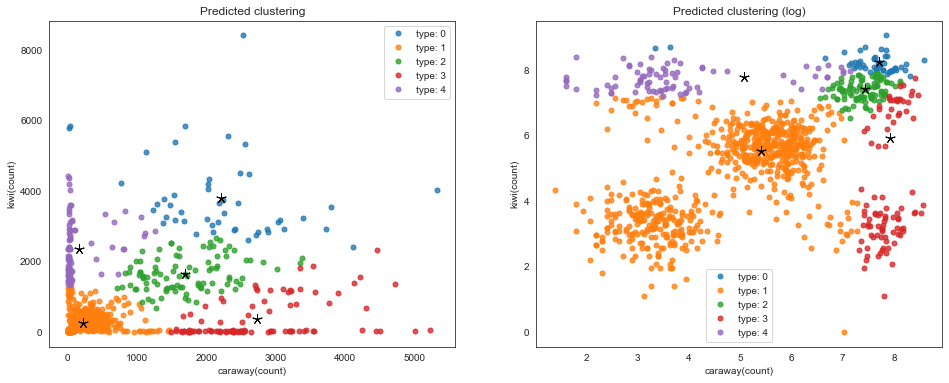

In [226]:
km1 = KMeans()
km1.fit(X)
km1.visualize_prediction(X)

 23%|██▎       | 23/100 [00:00<00:02, 26.34it/s]


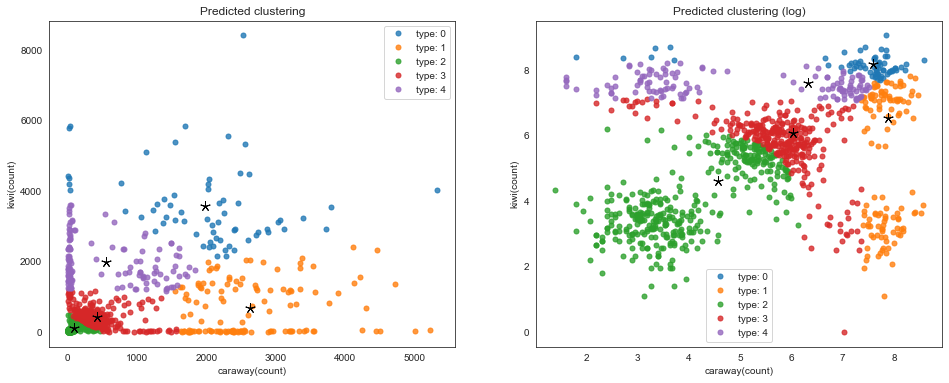

In [152]:
km2 = KMeans(init_method=2)
km2.fit(X)
km2.visualize_prediction(X)


 10%|█         | 10/100 [00:00<00:03, 23.81it/s]


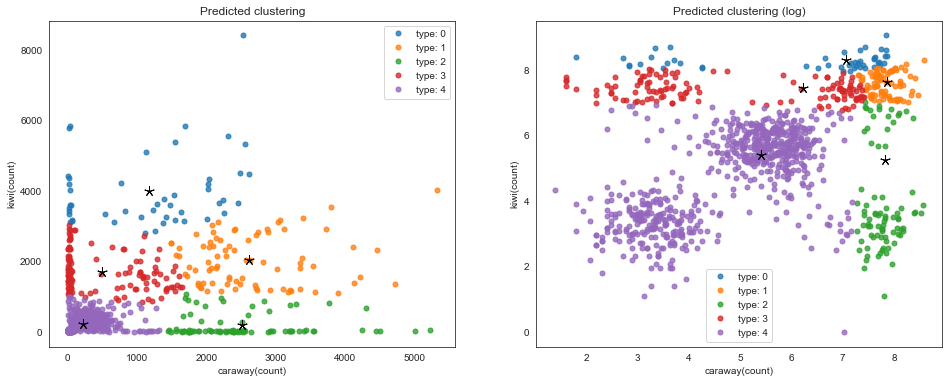

In [161]:
km3 = KMeans(init_method=3)
km3.fit(X)
km3.visualize_prediction(X)

Well so, initialization method 1 and 3 had quite the same results. Method 2 seemed to behave better (method 1-3 defined in the lecture notes:)

Various ways of initializing the centroids include:

1. choose K random points in space;
2. choose K random points from X and put the initial centroids there;
3. assign all points in X randomly to clusters Ck, then calculate centroids of these.

It's kind of obvious to me because I didn't produce the problem at the first time. We trained KMeans() with un-logged data but plotted it with logged data. That's the problem. The un-logged data (plots on the left) doesn't have a clear clustring pattern, so it's hard to do KMeanas clustering. We can retrain it here using logged data:

In [137]:
log = np.vectorize(lambda x: math.log(x)) 
X_log = log(X)

 15%|█▌        | 15/100 [00:00<00:03, 26.05it/s]


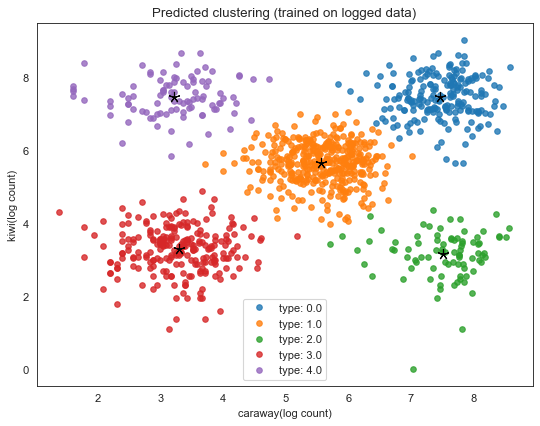

In [138]:
km_logged = KMeans()
km_logged.fit(X_log)
km_logged.visualize_log(X_log)


Nice hit in 5 epochs. I'd say that the three initialization wouldn't affect the performance much because 
1. the data on a log scale has a clear clustering pattern; 
2. the algorithm finds the optimal solution within <10 iterations (a pretty simple task); 
3. the data points are distributed across the space, so method 1,3 and 2 wouldn't have a clear difference than what they had when the data were not on a log scale.

Method 2 is more likely to have the initial centers clustered at where there's a crowd of points (on the bottom left in our case), so when performing the clustering, more clusters are formed at the bottom left due to local optimum. Thus when we visualize it on a log scale, the clustering seems more evenly distributed.

 22%|██▏       | 22/100 [00:00<00:02, 27.63it/s]


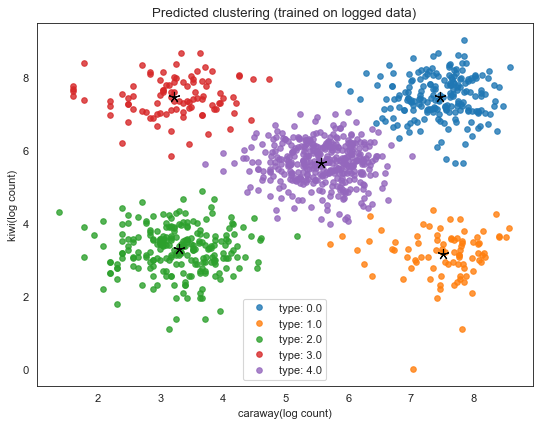

In [233]:
## initialization 2
km_logged2 = KMeans(init_method=2)
km_logged2.fit(X_log)
km_logged2.visualize_log(X_log)

  5%|▌         | 5/100 [00:00<00:04, 21.58it/s]


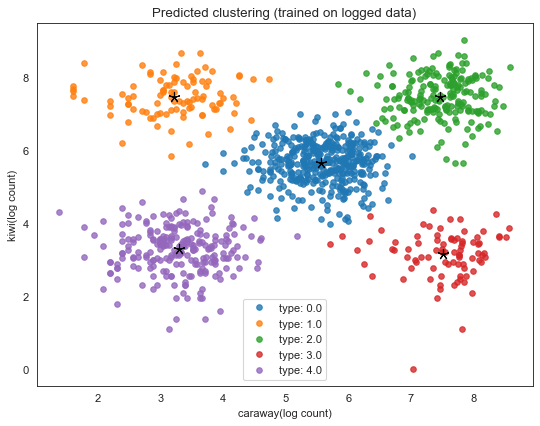

In [230]:
## initialization 3
km_logged3 = KMeans(init_method=3)
km_logged3.fit(X_log)
km_logged3.visualize_log(X_log)

## 2. mixture negative binomial fitting
Now you're going to use what you've learned about mixture models, and about the negative binomial distribution for RNA-seq data.

Write an expectation maximization algorithm to fit a mixture negative binomial distribution to Wiggins' data, for Q=5 components in the mixture.

Assume there is a common dispersion ϕ=0.3. This means that all you need to re-estimate in the EM algorithm are the means μ and mixture coefficients π for each mixture component.

Like K-means, EM is a local optimizer, so you will want to run your EM algorithm from multiple initial conditions, and take the best one. What is an appropriate statistic for choosing the "best" fit?

What are the estimated mean expression levels of Caraway and Kiwi in the five cell types, and the relative proportions of each cell type in the 1000 cells?

Visualize your result in a plot similar to Wiggins'.



In [110]:
from scipy.spatial import distance
from numpy.linalg import norm
from scipy.stats import nbinom 
from scipy.special import logsumexp
import numpy.random as rand
import math
class MixtureModel:
    """
    I'd say that this class is generally the same as KMeans, but the way to find labels is different
    """
    def __init__(self, init_method=1, k=5, phi=0.3, max_iter=100, diff_threshold=0.001):
        self.init_method = init_method
        self.k = k 
        self.pi = None  ## mixed coeff
        self.mus = None 
        self.max_iter = max_iter
        self.phi = phi  ## dispersion parameter
        self.nllh = float('inf')  ## negative loglikelihood, to be updated
        self.diff_threshold = diff_threshold  ## the threshold we'll use in iteration
        self.predicted_clusters = None
        
    def initialize_parameters(self, X):
        """
        initializes the centers (mus) in 3 ways, pi, and 
        """    
        pi = rand.dirichlet(np.ones(self.k),size=1).flatten()  ## initialize a normalized set of pi
        nllh = 0
        nllh_diff = float('inf')  ## initialize an infinitely big difference
        
        if self.init_method == 1:  ## assign random points in the space as the centers 
            min_x, min_y = np.min(X, axis= 0)
            max_x, max_y = np.max(X, axis= 0)
            mus = np.array(list(zip(rand.choice(np.linspace(int(math.floor(min_x)),
                                                             int(math.ceil(max_x)),
                                                             int(math.floor(max_x)-math.ceil(min_x))), self.k), 
                                     rand.choice(np.linspace(int(math.floor(min_y)),
                                                             int(math.ceil(max_y)),
                                                             int(math.floor(max_y)-math.ceil(min_y))), self.k))))
        elif self.init_method == 2:   ## assign random data points as the centers
            mus =  X[rand.choice(X.shape[0], self.k, replace=False), :]
        else:   ## assign each point to a random cluster
            rand_clusters = rand.randint(0, self.k, size=len(X))
            ## initialize a center list and then update using our random clusters
            mus = X[rand.choice(X.shape[0], self.k, replace=False), :]
            pi = rand.dirichlet(np.ones(self.k),size=1).flatten()
            pi, mus, predicted_clusters = self.maximize_expectation(X, pi, mus)  ## this also updates pi
        
        return pi, mus, nllh, nllh_diff
    
    def calc_pqx(self, X, pi, mus):
        """a helper function to calculate p(q|x)"""
        phi = self.phi
        return [[np.log(p) + nbinom.logpmf(point[0],1/phi,1/(1+mu[0]*phi)) + nbinom.logpmf(point[1],1/phi,1/(1+mu[1]*phi)) 
                 for p,mu in zip(pi,mus)] for point in X]

    def update_mu(self, X, post_p):
        """Updates mus based on posterior probabilities"""
        total_mu = np.sum(post_p, 0)
        ## caraway' on the x axis, so x[0]
        caraway_mus = np.divide(np.sum([np.multiply(pp, x[0]) for pp, x in zip(post_p, X)], 0), total_mu)
        ## kiwi' on the y axis, so x[0]
        kiwi_mus = np.divide(np.sum([np.multiply(pp, x[1]) for pp, x in zip(post_p, X)], 0), total_mu)  
        return np.array(list(zip(caraway_mus, kiwi_mus)))
        
    def maximize_expectation(self, X, pi, mus):    
        """returns updated mus and pi based on posterior probabilities"""
        post_p = np.exp([x - logsumexp(x) for x in self.calc_pqx(X, pi, mus)])  ## normalize, minus because log caculation (division -> minus)
        predicted_clusters = [np.argmax(prob) for prob in post_p]  ## be at the place with the highest probability
        mus = self.update_mu(X, post_p)    ## update mus based on posterior probobilities 
        pi = np.divide(np.sum(post_p, 0),len(X))   ## update pi (mixed coef)
        
        return pi, mus, predicted_clusters
    
    def update_nllh(self, X, pi, mus, nllh):
        """updates, and returns the difference"""
        new_nllh = -logsumexp(self.calc_pqx(X, pi, mus))
        nllh_diff = abs(new_nllh - nllh)
        return new_nllh, nllh_diff
    
    def fit(self, X):
        """We have a different approach here, we iterate a full number of given n_iterations and return the best try."""
        for i in tqdm(range(self.max_iter)):
            pi, mus, nllh, nllh_diff = self.initialize_parameters(X)
            ## iterate till the difference between new nllh and old is smaller than a threshold
            while nllh_diff > self.diff_threshold * nllh:
                pi, mus, predicted_clusters = self.maximize_expectation(X, pi, mus)  ## update mus and pi
                nllh, nllh_diff = self.update_nllh(X, pi, mus, nllh)
                print("Updating nllh... Current diff %f, threshold: %f"%(nllh_diff, self.diff_threshold * nllh))
                
            # Update if better performance
            if nllh < self.nllh:
                self.pi = pi
                self.nllh = nllh
                self.mus = mus
                self. predicted_clusters = predicted_clusters
    
    def predict(self, X):
        pi, mus, predicted_clusters = self.maximize_expectation(X, self.pi, self.mus)  
        return predicted_clusters
    
    def visualize_prediction(self, X, marker="o", alpha="0.8"):
        predicted_labels = self.predict(X)
        df = pd.DataFrame(np.c_[X, predicted_labels], columns=["caraway","kiwi","label"])
        
        ## do a log version
        X_log = log(X)
        df_log = pd.DataFrame(np.c_[X_log, predicted_labels], columns=["caraway","kiwi","label"])

        fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16,6))
        sns.set_style("white")
        
        for name, group in df.groupby("label"):
            ax1.plot(group.caraway, group.kiwi, marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
        for center in self.mus:
            ax1.plot(center[0], center[1], marker=(5,2), linestyle='', ms=10, c="k")
        
        for name, group in df_log.groupby("label"):
            ax2.plot(group.caraway, group.kiwi, marker='o', linestyle='', ms=5, label=f'type: {name}', alpha=0.8)
        for center in log(self.mus):
            ax2.plot(center[0], center[1], marker=(5,2), linestyle='', ms=10, c="k")
        
        ax1.set_title("Predicted clustering")
        ax1.set_xlabel("caraway(count)")
        ax1.set_ylabel("kiwi(count)")
        ax1.legend()
        
        ax2.set_title("Predicted clustering (log)")
        ax2.set_xlabel("caraway(count)")
        ax2.set_ylabel("kiwi(count)")
        ax2.legend()
        
        plt.show()

### Let's build the model and fit the data
By the way I started with max_iter==100, and found that typically 5 does the job. 

In [101]:
mm1 = MixtureModel(init_method=1, max_iter=5)
mm1.fit(X)

  0%|          | 0/5 [00:00<?, ?it/s]

Updating nllh... Current diff 7.546486, threshold: 0.007546
Updating nllh... Current diff 0.212017, threshold: 0.007334
Updating nllh... Current diff 0.102116, threshold: 0.007232
Updating nllh... Current diff 0.137170, threshold: 0.007095
Updating nllh... Current diff 0.279313, threshold: 0.006816
Updating nllh... Current diff 0.676340, threshold: 0.006140
Updating nllh... Current diff 1.668761, threshold: 0.004471
Updating nllh... Current diff 0.452125, threshold: 0.004019
Updating nllh... Current diff 0.013791, threshold: 0.004005


 20%|██        | 1/5 [00:08<00:33,  8.35s/it]

Updating nllh... Current diff 0.000899, threshold: 0.004004
Updating nllh... Current diff 7.665449, threshold: 0.007665
Updating nllh... Current diff 0.371155, threshold: 0.007294
Updating nllh... Current diff 0.191831, threshold: 0.007102
Updating nllh... Current diff 0.053133, threshold: 0.007049
Updating nllh... Current diff 0.034995, threshold: 0.007014
Updating nllh... Current diff 0.066629, threshold: 0.006948
Updating nllh... Current diff 0.308448, threshold: 0.006639
Updating nllh... Current diff 1.235750, threshold: 0.005404
Updating nllh... Current diff 1.306228, threshold: 0.004097
Updating nllh... Current diff 0.091817, threshold: 0.004005


 40%|████      | 2/5 [00:17<00:26,  8.81s/it]

Updating nllh... Current diff 0.002763, threshold: 0.004003
Updating nllh... Current diff 7.202882, threshold: 0.007203
Updating nllh... Current diff 0.287829, threshold: 0.006915
Updating nllh... Current diff 0.103729, threshold: 0.006811


 60%|██████    | 3/5 [00:20<00:12,  6.32s/it]

Updating nllh... Current diff 0.002231, threshold: 0.006809
Updating nllh... Current diff 7.485541, threshold: 0.007486
Updating nllh... Current diff 0.713946, threshold: 0.006772
Updating nllh... Current diff 0.609555, threshold: 0.006162
Updating nllh... Current diff 0.973718, threshold: 0.005188
Updating nllh... Current diff 0.960531, threshold: 0.004228
Updating nllh... Current diff 0.206539, threshold: 0.004021
Updating nllh... Current diff 0.013427, threshold: 0.004008


 80%|████████  | 4/5 [00:27<00:06,  6.44s/it]

Updating nllh... Current diff 0.002626, threshold: 0.004005
Updating nllh... Current diff 6.815454, threshold: 0.006815
Updating nllh... Current diff 0.015148, threshold: 0.006800
Updating nllh... Current diff 0.017945, threshold: 0.006782
Updating nllh... Current diff 0.007001, threshold: 0.006789
Updating nllh... Current diff 0.021734, threshold: 0.006811
Updating nllh... Current diff 0.015135, threshold: 0.006826


100%|██████████| 5/5 [00:33<00:00,  6.67s/it]

Updating nllh... Current diff 0.006534, threshold: 0.006820


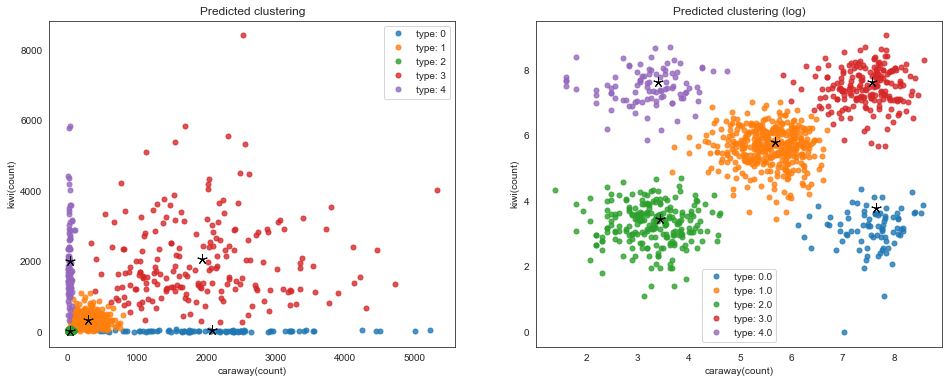

In [102]:
mm1.visualize_prediction(X)

### Let's try other initialization methods. 
I bet they are the same from visualization (and w/ max_iter=5)



  0%|          | 0/5 [00:00<?, ?it/s]

Updating nllh... Current diff 7.105845, threshold: 0.007106
Updating nllh... Current diff 0.516222, threshold: 0.006590
Updating nllh... Current diff 0.917230, threshold: 0.005672
Updating nllh... Current diff 1.362228, threshold: 0.004310
Updating nllh... Current diff 0.288868, threshold: 0.004021
Updating nllh... Current diff 0.009798, threshold: 0.004011


 20%|██        | 1/5 [00:05<00:23,  5.88s/it]

Updating nllh... Current diff 0.000510, threshold: 0.004011
Updating nllh... Current diff 4.114530, threshold: 0.004115
Updating nllh... Current diff 0.080021, threshold: 0.004035
Updating nllh... Current diff 0.010332, threshold: 0.004024
Updating nllh... Current diff 0.004318, threshold: 0.004020


 40%|████      | 2/5 [00:10<00:14,  4.88s/it]

Updating nllh... Current diff 0.001880, threshold: 0.004018
Updating nllh... Current diff 5.304369, threshold: 0.005304
Updating nllh... Current diff 1.141944, threshold: 0.004162
Updating nllh... Current diff 0.150047, threshold: 0.004012
Updating nllh... Current diff 0.004608, threshold: 0.004008


 60%|██████    | 3/5 [00:14<00:09,  4.56s/it]

Updating nllh... Current diff 0.000400, threshold: 0.004008
Updating nllh... Current diff 4.070470, threshold: 0.004070
Updating nllh... Current diff 0.027383, threshold: 0.004043
Updating nllh... Current diff 0.010852, threshold: 0.004032
Updating nllh... Current diff 0.005938, threshold: 0.004026


 80%|████████  | 4/5 [00:18<00:04,  4.41s/it]

Updating nllh... Current diff 0.003507, threshold: 0.004023
Updating nllh... Current diff 4.039579, threshold: 0.004040
Updating nllh... Current diff 0.035855, threshold: 0.004004


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]

Updating nllh... Current diff 0.001662, threshold: 0.004002


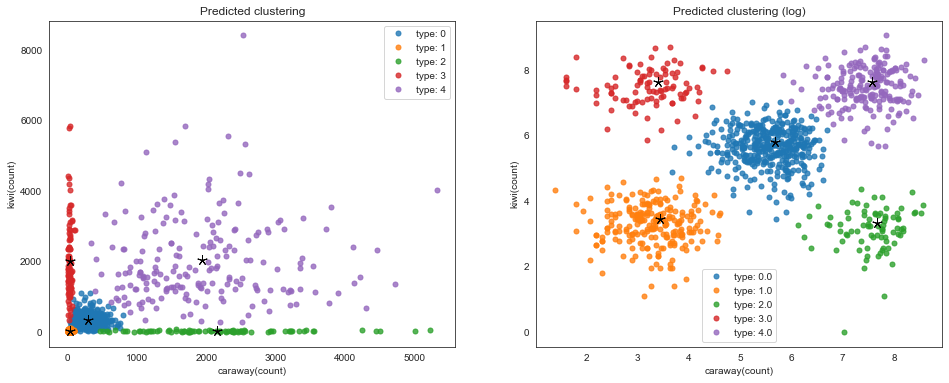

In [104]:
mm2 = MixtureModel(init_method=2, max_iter=5)
mm2.fit(X)
mm2.visualize_prediction(X)


  0%|          | 0/5 [00:00<?, ?it/s]

Updating nllh... Current diff 4.004973, threshold: 0.004005


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

Updating nllh... Current diff 0.001264, threshold: 0.004004
Updating nllh... Current diff 4.054169, threshold: 0.004054
Updating nllh... Current diff 0.042610, threshold: 0.004012
Updating nllh... Current diff 0.007634, threshold: 0.004004


 40%|████      | 2/5 [00:05<00:09,  3.11s/it]

Updating nllh... Current diff 0.000813, threshold: 0.004003
Updating nllh... Current diff 6.374421, threshold: 0.006374
Updating nllh... Current diff 1.214602, threshold: 0.005160
Updating nllh... Current diff 1.018860, threshold: 0.004141
Updating nllh... Current diff 0.130822, threshold: 0.004010
Updating nllh... Current diff 0.007349, threshold: 0.004003


 60%|██████    | 3/5 [00:11<00:08,  4.15s/it]

Updating nllh... Current diff 0.000770, threshold: 0.004002
Updating nllh... Current diff 4.013050, threshold: 0.004013
Updating nllh... Current diff 0.010763, threshold: 0.004002


 80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

Updating nllh... Current diff 0.000574, threshold: 0.004002
Updating nllh... Current diff 4.004155, threshold: 0.004004


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

Updating nllh... Current diff 0.000075, threshold: 0.004004


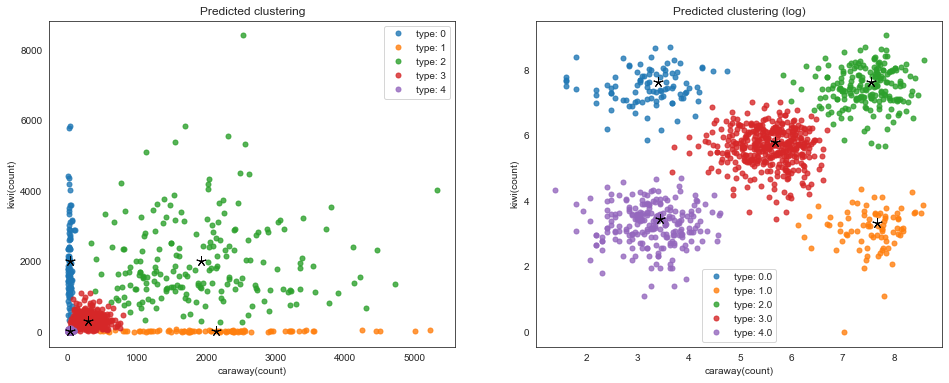

In [112]:
mm3 = MixtureModel(init_method=3, max_iter=5)
mm3.fit(X)
mm3.visualize_prediction(X)

They performed almost equally good, but the last method takes the least amount of While iterations. But this could also be attributed to that we have iterated once before we enter the While loop. I'd say initialization method 2 and 3 are both good.

### What are the estimated mean expression levels of Caraway and Kiwi in the five cell types, and the relative proportions of each cell type in the 1000 cells?

Let's take model 3 as our sample model.

In [143]:
from collections import Counter
def exp_level_mixturemodel(model):
    cluster_exp_count = np.array((list(Counter(sorted(model.predicted_clusters)).values())))
    exp = np.divide(cluster_exp_count, sum(cluster_exp_count))
    df = pd.concat([pd.DataFrame(exp), pd.DataFrame(model.mus)],axis=1)
    df.columns = ['proportion', 'Caraway mean count', 'Kiwi mean count']
    return df


In [147]:
exp_level_mixturemodel(mm3)


,proportion,Caraway mean count,Kiwi mean count
0,0.095,29.943522,2009.767483
1,0.083,2143.032265,27.502969
2,0.200,1919.241649,2019.630835
3,0.389,293.556764,323.983635
4,0.233,31.127316,31.338055


For the log scale Kmeans (for question3, but I put in above this section), the proportion looks different:


In [151]:
def exp_level_kmeans(model):
    cluster_exp_count = np.array((list(Counter(sorted(model.predict(X_log))).values())))
    exp = np.divide(cluster_exp_count, sum(cluster_exp_count))
    df = pd.concat([pd.DataFrame(exp), pd.DataFrame(model.centers)],axis=1)
    df.columns = ['proportion', 'Caraway mean count (log scale)', 'Kiwi mean count (log scale)']
    return df
exp_level_kmeans(km_logged)

,proportion,Caraway mean count (log scale),Kiwi mean count (log scale)
0,0.198,7.461934,7.465811
1,0.385,5.563466,5.655408
2,0.086,7.504845,3.155116
3,0.235,3.291772,3.285672
4,0.096,3.220398,7.462902
